In [10]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage.io import imread
from skimage import color, exposure
from skimage.transform import rescale
from skimage.util import view_as_blocks
from multiprocessing import Pool
from skimage.color import rgb2gray
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import multiprocess as mp
import pickle
from multiprocessingNotebook import runt

PICKLE_PATH = 'test_data.pickle'

NUM_TRAINING_IMAGES = 70000
NUM_TESTING_IMAGES = 50

NUM_SPACES_PER_BOARD = 2
PICTURE_DIMENSIONS = 400
block_width = PICTURE_DIMENSIONS // 8
block_height = PICTURE_DIMENSIONS // 8
num_channels = 3

In [11]:
# opens the chess boards.zip file into the chessBoards object
zipFilePath = '../chess boards.zip'
chessBoards = ZipFile(zipFilePath, 'r')

test = []
train = []
newpath = True

# extract the file names from the train and test folders in the zip archive
for file in chessBoards.namelist():
    # fills the file names from within the dataset subfolder
    """if file[:13] == 'dataset/test/':
        datasetTest.append(file)
    if file[:14] == 'dataset/train/':
        datasetTrain.append(file)"""

    if file[:4] == 'test':
        test.append(file)
    if file[:5] == 'train':
        train.append(file)

    # find any new file paths not accounted for
    """if file[:13] != 'dataset/test/' and \
        file[:14] != 'dataset/train/' and \
        file[:4] != 'test'and \
        file[:5] != 'train' and \
        newpath:
        print("new path: ", file)
        newpath = False"""

print("Files in test: ", len(test))
print("Files in train: ", len(train))

Files in test:  20000
Files in train:  80000


In [12]:
# Parallel Loads Board Images for Training Purposes
def HogTransform(img):
    first_image_gray = color.rgb2gray(img)

    fd, hog_image = hog(
        first_image_gray,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys',
        feature_vector=True
    )

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)
    return hog_image_uint8

def read_and_store_modified_chess_images():
    return    

def fen_from_position(position, fen_string):
    rows = position // 8
    cols = position % 8
    
    character = fen_string[rows * 8 + cols]

    if character.isdigit():
        return ' ' * int(character)
    else:
        return character

def fen_from_filename(filename):
    parts = filename.split('/')
    fen_part = parts[-1].split('.')[0]

    fen_string = ''.join([' ' * int(char) if char.isdigit() else char for char in fen_part])
    fen_string = fen_string.replace('-', '')

    return fen_string

src = zipFilePath
random.shuffle(train)

print("Running...")
lock = mp.Lock()
manager = mp.Manager()
#data_dict = manager.dict({'fenstring': [], 'data': []})
data_dict = manager.list()
with mp.Pool(processes=10) as p:
    args = [(fileName, src, fen_from_filename, fen_from_position, NUM_SPACES_PER_BOARD, data_dict) for fileName in train[:NUM_TRAINING_IMAGES]]
    results = p.starmap(runt, args)

# Access the shared dictionary
print(len(data_dict))

combined_results = {'fenstring': [], 'data': []}

# Initialize lists to store all data and fenstring items
all_data_items = []
all_fenstring_items = []

for result in data_dict:
    # Extend all_data_items with result['data']
    all_data_items.extend(result['data'])
    
    # Extend all_fenstring_items with result['fenstring']
    all_fenstring_items.extend(result['fenstring'])

# Assign the combined lists to combined_results
combined_results['data'] = all_data_items
combined_results['fenstring'] = all_fenstring_items

joblib.dump(combined_results, PICKLE_PATH)
read_and_store_modified_chess_images()
    


Running...
262443


In [ ]:
t = data_dict
print('f')

In [ ]:
# Sequential loads Board Images for Training Purposes
def HogTransform(img):
    first_image_gray = color.rgb2gray(img)

    fd, hog_image = hog(
        first_image_gray,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys',
        feature_vector=True
    )

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)
    return hog_image_uint8

def read_and_store_modified_chess_images():
    def fen_from_position(position, fen_string):
        rows = position // 8
        cols = position % 8
        
        # Get the character at the corresponding position in the FEN string
        character = fen_string[rows * 8 + cols]

        # If the character is a number, return that many empty squares
        if character.isdigit():
            return ' ' * int(character)
        else:
            return character

    def fen_from_filename(filename):
        # Split the filename by '/'
        parts = filename.split('/')
        # Remove File Extension
        fen_part = parts[-1].split('.')[0]

        # Replace digits with spaces
        fen_string = ''.join([' ' * int(char) if char.isdigit() else char for char in fen_part])

        # Remove dashes
        fen_string = fen_string.replace('-', '')

        return fen_string

    def loadImages(src, fileNames, destinationPickleFile, limit):
        data = {'fenstring': [], 'data': []}
        count = 0


        for file in fileNames:
            print("File:", file, "Count:", count)

            if count >= limit:
                break
            
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                im = imread(os.path.join(src, file))
                fenString = fen_from_filename(file)

                patches = view_as_blocks(im, block_shape=(block_height, block_width, num_channels)).reshape(-1, block_height, block_width, num_channels)
                spaceTilesStored, boardPosition = 0, 0
                
                for patch in patches:
                    patchType = fen_from_position(boardPosition, fenString)
                    if patchType == ' ':
                        if spaceTilesStored > NUM_SPACES_PER_BOARD:
                            continue
                        spaceTilesStored += 1
                    
                    hog_features = HogTransform(patch)
                    data['data'].append(hog_features)
                    data['fenstring'].append(patchType)
                    boardPosition += 1

            count += 1
        joblib.dump(data, destinationPickleFile)
        print(len(data))

    random.shuffle(train)  # Shuffle the file names list to pick a random file
    loadImages(zipFilePath, train, PICKLE_PATH, NUM_TRAINING_IMAGES)

read_and_store_modified_chess_images()

In [4]:
# Read Pickle File For Image Training
def load_pickle_file(file_path):
    try:
        data = joblib.load(file_path)
        return data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        return None

# Load the pickle file and output it to a variable
loaded_train_data = load_pickle_file(PICKLE_PATH)

print("Num tiles stored: " + str(len(loaded_train_data['data'])))

first_image = loaded_train_data['data'][1]
print(loaded_train_data['fenstring'][1])

Num tiles stored: 18770
 


File: test/1R1k2B1-PK6-8-2b5-4b3-8-8-n1B5.jpeg Count: 0
File: test/8-NRP4k-3r3R-8-6p1-Q1r1N3-2K4b-R5RR.jpeg Count: 1
File: test/1K1q1k2-8-8-8-8-4Q3-8-B7.jpeg Count: 2
File: test/4R3-8-8-3r3r-8-K7-8-4k2N.jpeg Count: 3
File: test/8-5B2-8-4P2k-K1N5-8-8-8.jpeg Count: 4
File: test/7N-B2k4-8-2r5-8-2K3R1-n5p1-8.jpeg Count: 5
File: test/1b4bk-6R1-8-8-2K3B1-8-8-8.jpeg Count: 6
File: test/2R2R2-8-RkP2N2-2Rp1P2-5N2-KQn5-8-1R2N3.jpeg Count: 7
File: test/B5Q1-5p2-r1K5-4Q1b1-5b2-n1b5-2kB3N-N6q.jpeg Count: 8
File: test/6R1-1K6-5N2-B7-7k-2N5-7N-8.jpeg Count: 9
File: test/8-K7-6R1-2k2r1P-8-8-7Q-8.jpeg Count: 10
File: test/1qk5-K7-R7-1n4B1-2BN1R2-2Q3Rp-7P-8.jpeg Count: 11
File: test/1K6-2R3P1-2P5-2P2R2-rb6-3qBq2-3k4-rn4r1.jpeg Count: 12
File: test/8-8-b5N1-8-1n1B4-8-R7-3KRk2.jpeg Count: 13
File: test/3bb3-Pp6-N7-8-2BP2r1-5k2-2Kp4-6N1.jpeg Count: 14
File: test/8-1P5N-8-5N1q-4k3-8-PN3QQ1-1KQ5.jpeg Count: 15
File: test/3R1R2-8-8-5k2-1B2P3-8-p7-K7.jpeg Count: 16
File: test/2b5-p7-1p1k3b-2n5-1K6-p2N4-8-1r6.j

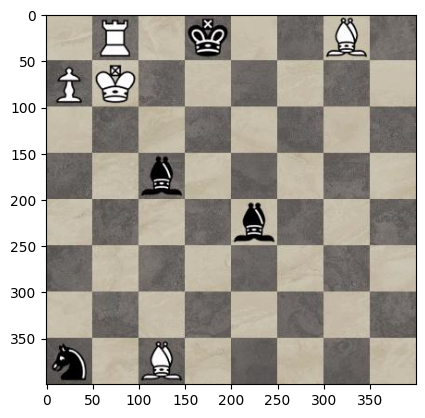

In [5]:
# Loads Board Images For Testing Purposes
def load_test_images(src, fileNames, limit):
    count = 0
    testImages = []
    for file in fileNames[:NUM_TESTING_IMAGES]:
        print("File:", file, "Count:", count)
        if count >= limit:
            break
        if file.endswith('.jpg') or file.endswith('.jpeg'):
            im = imread(os.path.join(src, file))
            fenString = file
            testImages.append((im, fenString))
            count += 1
    return testImages

random.shuffle(test)  # Shuffle the file names list to pick a random file
loaded_test_images = load_test_images(zipFilePath, test, NUM_TESTING_IMAGES)
first_image = loaded_test_images[0][0]
plt.imshow(first_image)
plt.show()

In [ ]:
def SVM_Predict_Individual_Pieces():
    
    X = np.array(loaded_train_data['data'])
    y = np.array(loaded_train_data['fenstring'])

    # Filter out data where fenstring is not ' '
    X_filtered = [X[i] for i, fenstring in enumerate(loaded_train_data['fenstring']) if fenstring != ' ']
    y_filtered = [fenstring for fenstring in loaded_train_data['fenstring'] if fenstring != ' ']

    # Flatten each HOG image in X_filtered
    X_flat_filtered = [img.flatten() for img in X_filtered]

    # Convert to numpy array
    X_flat_filtered = np.array(X_flat_filtered)

    # Encode FEN strings into numerical labels
    label_encoder = LabelEncoder()
    y_encoded_filtered = label_encoder.fit_transform(y_filtered)

    # Split the filtered data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat_filtered, y_encoded_filtered, test_size=0.2, random_state=42)

    # Train SVM classifier
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)

    # Predict FEN string labels for the test set
    y_pred = svm_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_encoder.classes_)
    disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SVM_Predict_Individual_Pieces()

In [13]:
# Partitions the training data for use in the SVM classifier
def SVM_Partition_Data():
    X = np.array(loaded_train_data['data'])
    y = np.array(loaded_train_data['fenstring'])

    # Filter out data where fenstring is not ' '
    X_filtered = [X[i] for i, fenstring in enumerate(loaded_train_data['fenstring']) if fenstring != 'l']
    y_filtered = [fenstring for fenstring in loaded_train_data['fenstring'] if fenstring != 'l']

    # Flatten each HOG image in X_filtered
    X_flat_filtered = [img.flatten() for img in X_filtered]

    # Convert to numpy array
    X_flat_filtered = np.array(X_flat_filtered)

    # Encode FEN strings into numerical labels
    label_encoder = LabelEncoder()
    y_encoded_filtered = label_encoder.fit_transform(y_filtered)

    # Split the filtered data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat_filtered, y_encoded_filtered, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = SVM_Partition_Data()

In [14]:
# Fits the training model to the SVM model
def SVM_Fit_Model():

    # Train SVM classifier
    # Define the pipeline with the SVM classifier
    svm_classifier = Pipeline(steps=[ 
        ("svm", SVC(kernel='linear', max_iter=2000, random_state=42, probability=True, C = .1, coef0= 0, gamma = .1)) 
    ])

    svm_classifier.fit(X_train, y_train)

    joblib.dump(svm_classifier, 'svm_classifier.pkl')

SVM_Fit_Model()

C:\Users\jjgei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted String: 1R1k2B1-RK6-8-2b5-4b3-8-8-n1B5
Actual String: 1R1k2B1-PK6-8-2b5-4b3-8-8-n1B5
The strings are different.
1
Predicted String: 8-NRR4k-3r3R-8-6r1-Q1r1N3-2K4b-R5RR
Actual String: 8-NRP4k-3r3R-8-6p1-Q1r1N3-2K4b-R5RR
The strings are different.
3
Predicted String: 1K1q1k2-8-8-8-8-4Q3-8-B7
Actual String: 1K1q1k2-8-8-8-8-4Q3-8-B7
The strings are the same.
3
Predicted String: 4R3-8-8-3r3r-8-K7-8-4k2N
Actual String: 4R3-8-8-3r3r-8-K7-8-4k2N
The strings are the same.
3
Predicted String: 8-5B2-8-4R2k-K1N5-8-8-8
Actual String: 8-5B2-8-4P2k-K1N5-8-8-8
The strings are different.
4
Predicted String: 7N-B2k4-8-2R5-8-2K3R1-n5b1-8
Actual String: 7N-B2k4-8-2r5-8-2K3R1-n5p1-8
The strings are different.
6
Predicted String: 1b4bk-6R1-8-8-2K3B1-8-8-8
Actual String: 1b4bk-6R1-8-8-2K3B1-8-8-8
The strings are the same.
6
Predicted String: 2R2R2-2b3b1-RkR2N2-2RR1Rb1-1b3N2-KQn5-8-1R2N3
Actual String: 2R2R2-8-RkP2N2-2Rp1P2-5N2-KQn5-8-1R2N3
The strings are different.
36
Predicted String: B5Q1-5R2-r1

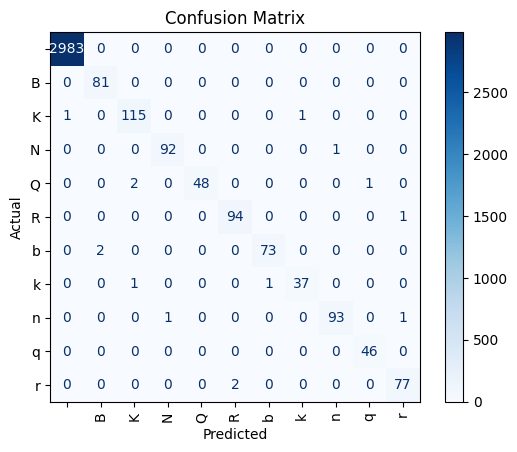

In [15]:
# Predicts the testing boards
def SVM_Classifier():
    def list_to_fen(input_list):
        fen_string = ""
        empty_count = 0
        line_count = 0
        
        for item in input_list:
            if line_count > 7:
                if empty_count > 0:
                    fen_string += str(empty_count)
                    empty_count = 0
                fen_string += str('-')
                line_count = 0

            line_count += 1
            if item == ' ':
                empty_count += 1
                
            else:
                if empty_count > 0:
                    fen_string += str(empty_count)
                    empty_count = 0
                fen_string += str(item)
        
        if empty_count > 0:
            fen_string += str(empty_count)
        
        # Removing ',', ']', and '[' from the fen_string
        fen_string = fen_string.replace("'", '').replace(']', '').replace('[', '')
        
        return fen_string

    def extract_fen_from_path(file_path):
        parts = file_path.split('/')
        parts2 = parts[1].split('.')
        return parts2[0]

    def SVM_Predict_Test_Board():
        correct = 0
        incorrect_chars = 0
        for image, _ in loaded_test_images:
            transformed_image = image
            patches = view_as_blocks(image, block_shape=(block_height, block_width, num_channels)).reshape(-1, block_height, block_width, num_channels)
            
            predicted_fenstring = []

            for patch in patches:

                hog_features = HogTransform(patch)
                #hog_features = patch
        
                flattened_features = hog_features.flatten()  # Flatten the features
                predicted_outcome = svm_classifier.predict([flattened_features[:2500]])
                predicted_class = label_encoder.inverse_transform(predicted_outcome) 

                predicted_fenstring.append(predicted_class)
            predicted_fenstring = list_to_fen(predicted_fenstring)
            actual_fenstring = extract_fen_from_path(_)
            print("Predicted String: " + predicted_fenstring)
            print("Actual String: " + actual_fenstring)
            if predicted_fenstring == actual_fenstring:
                print("The strings are the same.")
                correct += 1
            else:
                print("The strings are different.")
                # Count the number of different characters
                for pred_char, actual_char in zip(predicted_fenstring, actual_fenstring):
                    if pred_char != actual_char:
                        incorrect_chars += 1
            print(incorrect_chars)
        total_images = correct + incorrect_chars
        print(incorrect_chars / total_images)
        return

    svm_classifier = load_pickle_file('svm_classifier.pkl')

    # Predict FEN string labels for the test set
    y_pred = svm_classifier.predict(X_test)

    SVM_Predict_Test_Board()

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Get the unique class labels predicted by the classifier
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))

    # Display confusion matrix with correct labels
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_encoder.inverse_transform(unique_labels))
    disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SVM_Classifier()